## Analyse the results



In [ ]:
# load the relevant modules for the analysis

import os
from pathlib import Path

import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pl_temp_fit import Exp_data_utils, config_utils

import seaborn as sns

sns.set_theme(
    context="notebook",
    style="white",
    palette="deep",
    font="sans-serif",
    font_scale=0.6,
    color_codes=True,
    rc=None,
)

os.chdir("..")
# access the right directory


In [38]:
databse_path = Path("fit_experimental_emcee_pl/fit_data_base/")
add_for_ssh = "/run/user/1000/gvfs/sftp:host=lcmdlc3.epfl.ch,user=mazzouzi"
json_files = list(databse_path.glob("*.json"))
list_model_config = []
for _id, json_file in enumerate(json_files):
    model_config, model_config_save = config_utils.load_model_config(
        json_file.name.replace(".json", ""),
        database_folder=databse_path,
    )
    if os.path.exists(
        add_for_ssh
        + model_config_save["save_folder"]
        + "/sampler.h5"
    ):
        filename = (
            add_for_ssh
            + model_config_save["save_folder"]
            + "/sampler.h5"
        )
        try:
            reader = emcee.backends.HDFBackend(filename, name="multi_core")
            if not reader.initialized:
                print("multi_core empty file")
                continue
            if reader.iteration == 0:
                print("empty file")
                continue
            distribution = reader.get_chain(flat=True)
        except AttributeError:
            print("check if single core")

            reader = emcee.backends.HDFBackend(filename, name="single_core")
            if not reader.initialized:
                print("empty file")
                continue
            distribution = reader.get_chain(flat=True)

        true_parameters = list(np.mean(distribution, axis=0))
        model_config_save["mean"] = [f"{x:.3f}" for x in true_parameters]
        model_config_save["num_iteration"] = reader.iteration
        log_prob = reader.get_log_prob(flat=True)
        model_config_save["max_log_prob"] = np.max(log_prob)
        list_model_config.append(model_config_save)
if len(list_model_config) == 0:
    print("no data")
else:
    df_all = pd.DataFrame(list_model_config)
    df_all.sort_values(by="date", ascending=False, inplace=True)
df_all["csv_name_pl"] = df_all["csv_name_pl"].apply(
    lambda x: x.split("/")[-1]
)
df_all[["csv_name_pl", "num_iteration", "max_log_prob"]]

,csv_name_pl,num_iteration,max_log_prob
0,Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_s...,2660,-39.013321
1,Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_s...,2260,-60.463153
2,Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_s...,2661,-39.013321
3,L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024...,2734,-35.725393
4,L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024...,1914,-37.254860
5,Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_s...,3582,-36.874725
6,Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_s...,4657,-34.394970
7,L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024...,140,-74.460650
8,L8BO-fresh-300K_G0_750.0nm_1350.0nm_15-06-2024...,2174,-46.499944


In [26]:
test_id = df_all["test_id"].loc[6]
model_config, model_config_save = config_utils.load_model_config(
    test_id, database_folder=databse_path
)

filename = add_for_ssh+  model_config_save["save_folder"] + "/sampler.h5"
reader = emcee.backends.HDFBackend(filename, name="multi_core")
distribution = reader.get_chain(discard=0, flat=True)

number of iterations 2439
-31.05937189517202


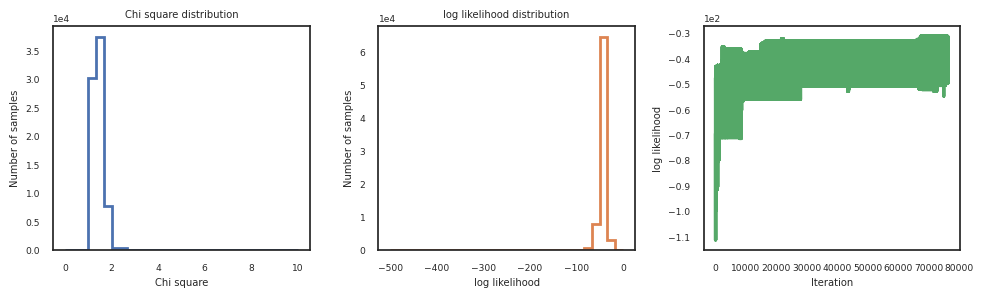

In [27]:
import importlib

from pl_temp_fit import plot_utils

importlib.reload(plot_utils)
plot_utils.plot_fit_statistics(
    reader,
    range_log_prior=(-500, 0),
    discard=50,
    range_chi_square=(0, 10),
    filter_log_likelihood=True,
)

(<Figure size 1000x750 with 5 Axes>,
 array([<Axes: ylabel='EX_E'>, <Axes: ylabel='EX_sigma'>,
        <Axes: ylabel='EX_Li'>, <Axes: ylabel='EX_Lo'>,
        <Axes: xlabel='step number', ylabel='EX_hO'>], dtype=object))

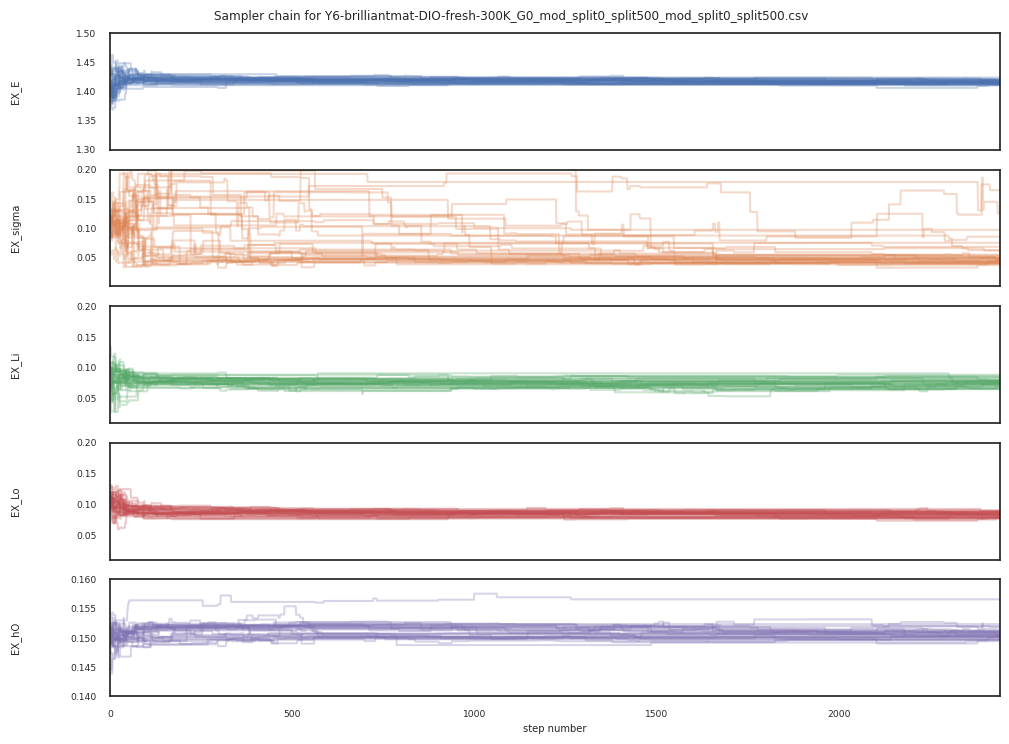

In [29]:
plot_utils.plot_chains(reader, model_config_save, discard=0)

/media/mohammed/Work/pl_temp_fit/src/pl_temp_fit/plot_utils.py:294: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


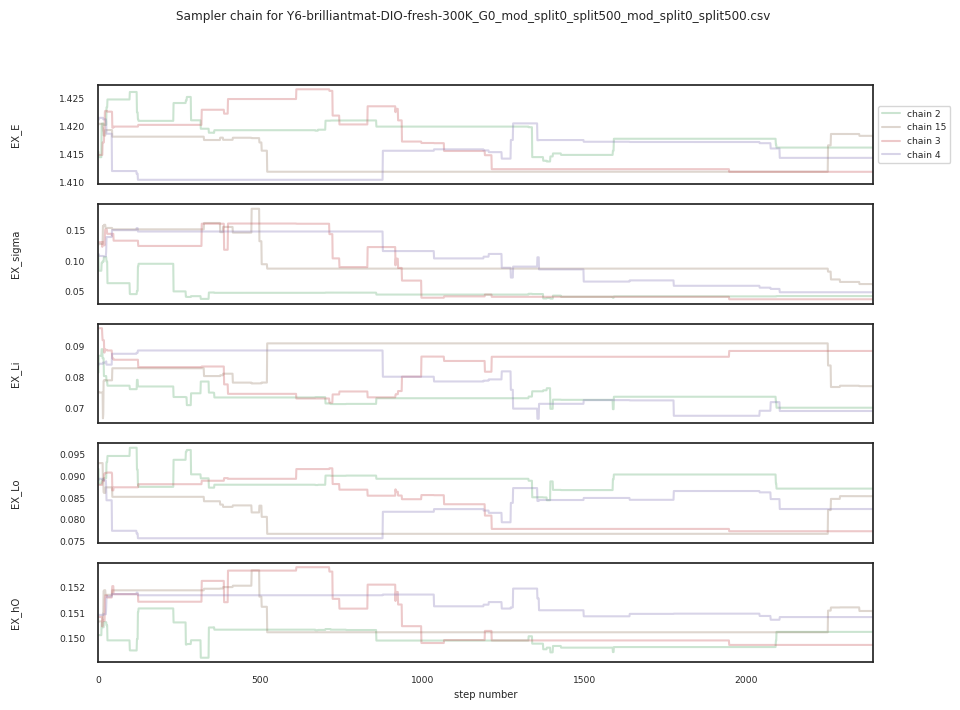

In [30]:
plot_utils.plot_diff_chains(
    reader,
    model_config_save,
    discard=50,
    chains_list=[2, 15, 3, 4],
)

(1.0, 1.8)

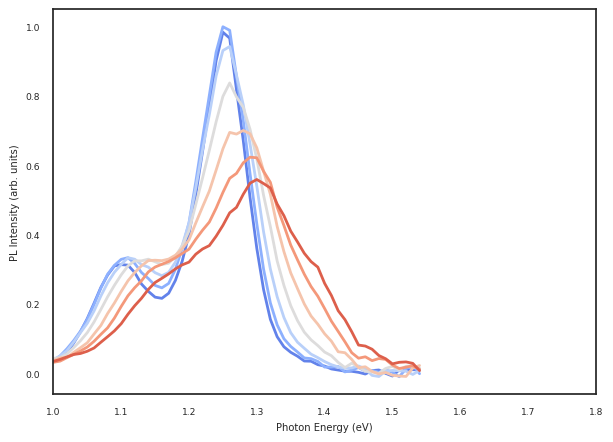

In [31]:
def plot_pl_data(
    truemodel_pl, temperature_list, hws, title="Experimental Data"
):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    data_true_plot = truemodel_pl.reshape(len(hws), -1) / max(
        truemodel_pl.reshape(-1, 1)
    )
    import seaborn as sns

    color_list = sns.color_palette("coolwarm", len(temperature_list))
    for i in range(len(temperature_list)):
        ax.plot(
            hws,
            data_true_plot[:, i],
            label="" + str(temperature_list[i]) + " K",
            # linestyle="--",
            color=color_list[i],
            linewidth=2,
        )

    ax.set_xlabel("Photon Energy (eV)")
    ax.set_ylabel("PL Intensity (arb. units)")

    return fig, ax


csv_name = add_for_ssh+  model_config_save["csv_name_pl"]
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
fig, ax = plot_pl_data(
    Exp_data, temperature_list, hws, title="Experimental Data"
)
ax.set_xlim(1, 1.8)

In [34]:
filter_log_likelihood = (
    "blobs['log_likelihood'] > max(blobs['log_likelihood']) * 2"
)
model_config_save["csv_name_pl"] = add_for_ssh+  model_config_save["csv_name_pl"]
plot_utils.plot_fit_to_experimental_data(
    model_config_save,
    model_config,
    reader,
    discard=0,
    filter_log_likelihood=filter_log_likelihood,
)

FileNotFoundError: [Errno 2] No such file or directory: '/run/user/1000/gvfs/sftp:host=lcmdlc3.epfl.ch,user=mazzouzi/run/user/1000/gvfs/sftp:host=lcmdlc3.epfl.ch,user=mazzouzi/home/mazzouzi/pl_temp_fit/dat_hanbo_311024/csv/Y6-brilliantmat-DIO-fresh-300K_G0_mod_split0_split500_mod_split0_split500.csv'

(<Figure size 1000x700 with 5 Axes>,
 array([<Axes: ylabel='EX_E'>, <Axes: ylabel='EX_sigma'>,
        <Axes: ylabel='EX_Li'>, <Axes: ylabel='EX_Lo'>,
        <Axes: ylabel='EX_hO'>], dtype=object))

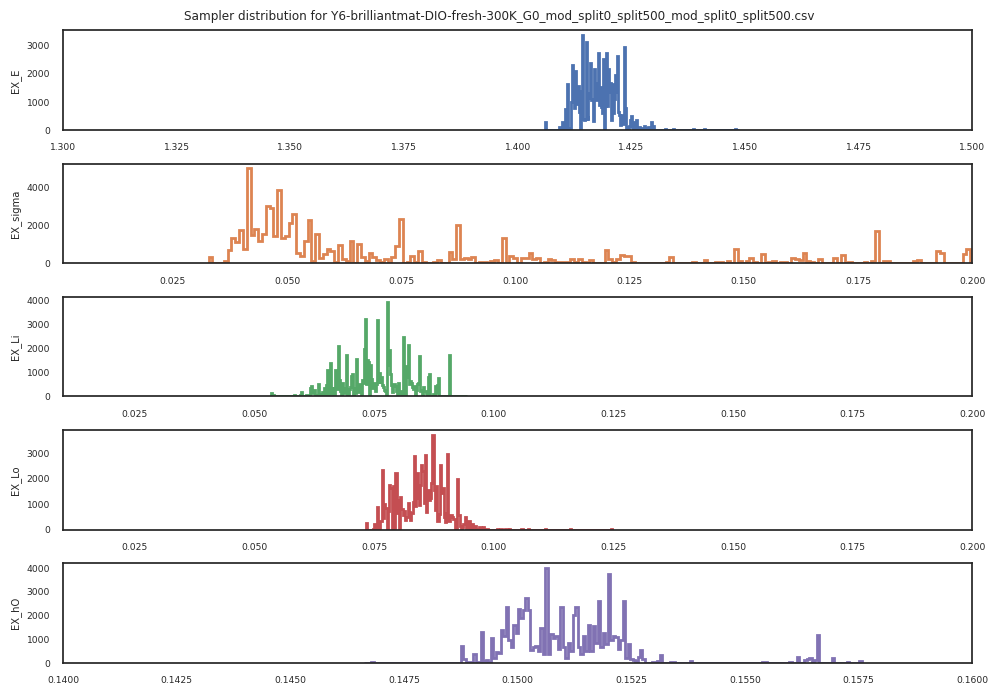

In [35]:
importlib.reload(plot_utils)
plot_utils.plot_distribution(
    reader,
    model_config_save,
    discard=0,
    filter_log_likelihood=filter_log_likelihood,
)

(<Figure size 1250x1250 with 20 Axes>,
 array([[<Axes: ylabel='EX_E'>, None, None, None, None],
        [<Axes: xlabel='EX_E', ylabel='EX_sigma'>, <Axes: >, None, None,
         None],
        [<Axes: xlabel='EX_E', ylabel='EX_Li'>,
         <Axes: xlabel='EX_sigma', ylabel='EX_Li'>, <Axes: >, None, None],
        [<Axes: xlabel='EX_E', ylabel='EX_Lo'>,
         <Axes: xlabel='EX_sigma', ylabel='EX_Lo'>,
         <Axes: xlabel='EX_Li', ylabel='EX_Lo'>, <Axes: >, None],
        [<Axes: xlabel='EX_E', ylabel='EX_hO'>,
         <Axes: xlabel='EX_sigma', ylabel='EX_hO'>,
         <Axes: xlabel='EX_Li', ylabel='EX_hO'>,
         <Axes: xlabel='EX_Lo', ylabel='EX_hO'>, <Axes: xlabel='EX_hO'>]],
       dtype=object))

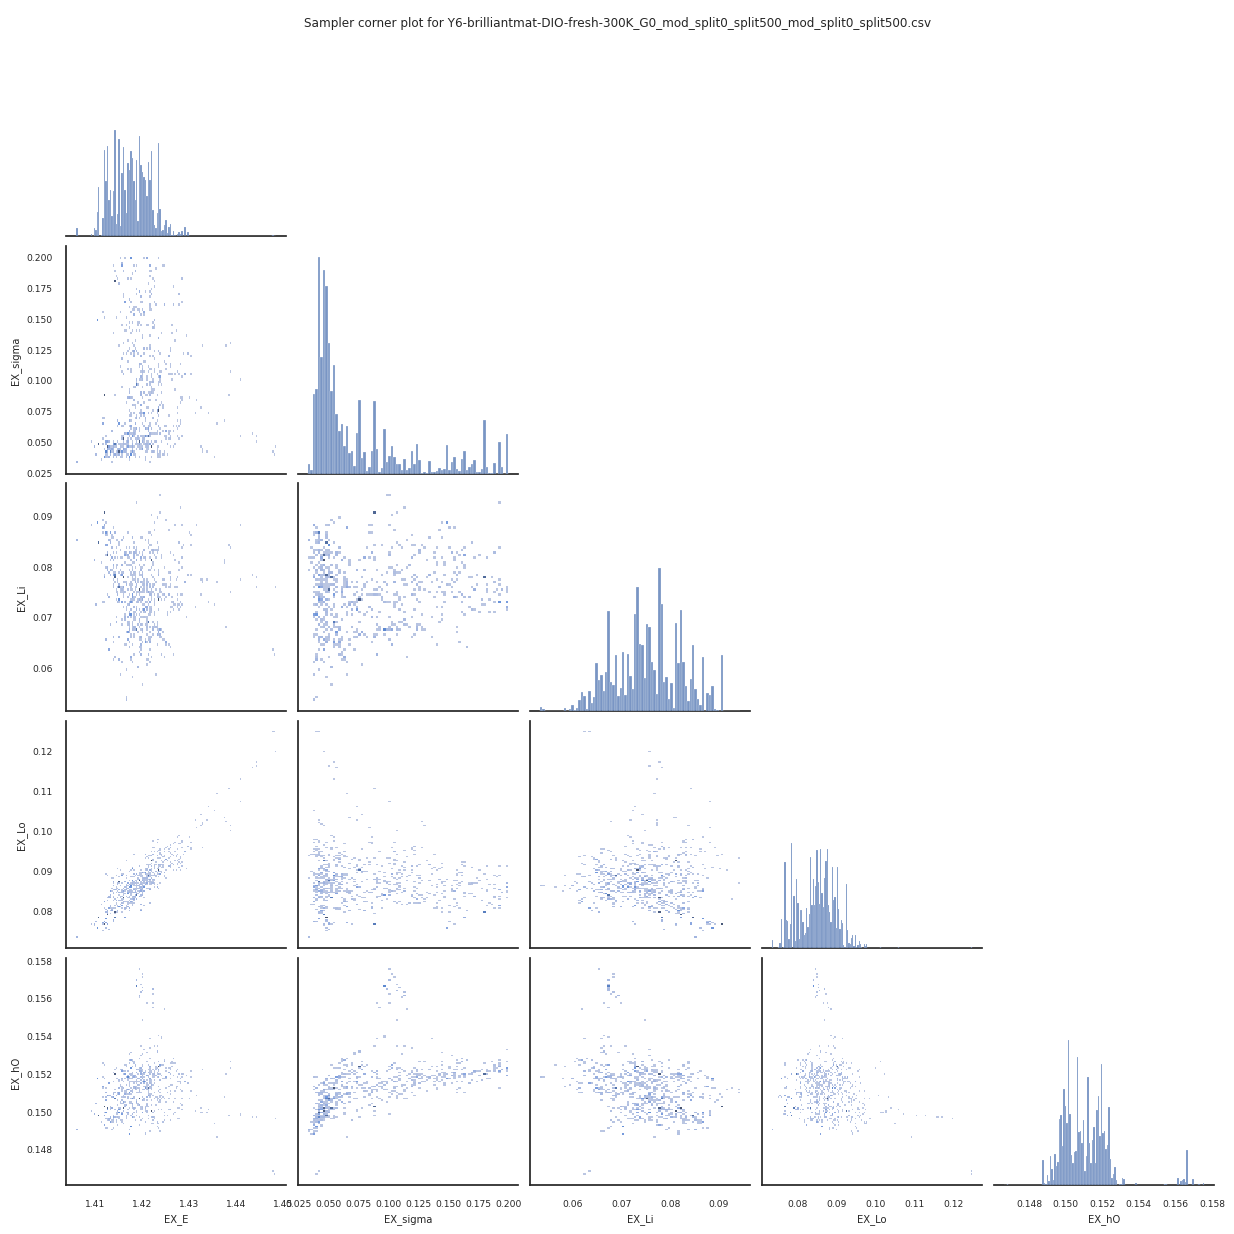

In [20]:
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
filter_log_likelihood = (
    "blobs['log_likelihood'] > max(blobs['log_likelihood']) * 2"
)
plot_utils.plot_corner(
    reader,
    model_config_save,
    discard=0,
    filter_log_likelihood=filter_log_likelihood,
)

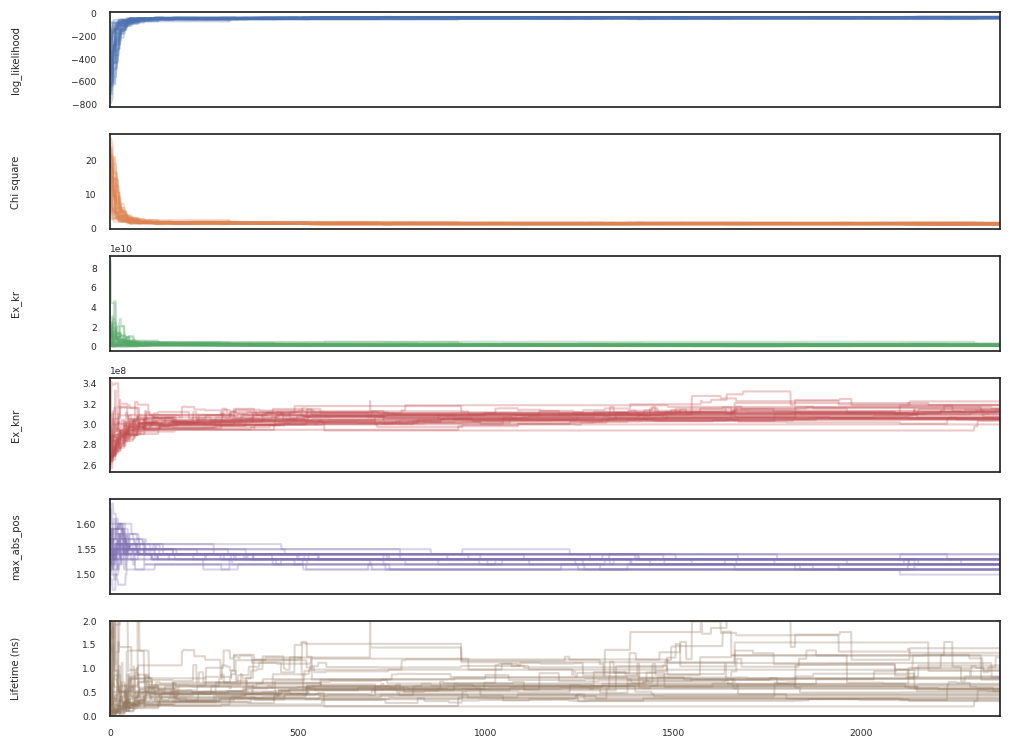

In [22]:
def plot_blobs_chain(
    reader, model_config_save, discard=0, filter_log_likelihood=None
):
    blobs = reader.get_blobs(discard=discard)
    num_blobs = len(blobs.dtype.names)
    fig, axes = plt.subplots(
        num_blobs + 1, figsize=(10, 1.5 * num_blobs), sharex=True
    )
    for i in range(num_blobs):
        ax = axes[i]
        ax.plot(blobs[blobs.dtype.names[i]], alpha=0.3, color="C" + str(i))
        ax.set_xlim(0, len(blobs))
        ax.set_ylabel(blobs.dtype.names[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    lifetime = 1 / (blobs["Ex_kr"] + blobs["Ex_knr"]) * 1e9
    ax = axes[i + 1]
    ax.plot(lifetime, alpha=0.3, color="C" + str(i + 1))
    ax.set_xlim(0, len(blobs))
    ax.set_ylabel("Lifetime (ns)")
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylim(0, 2)
    fig.tight_layout()


plot_blobs_chain(reader, model_config_save, discard=0)

number of iterations 2370


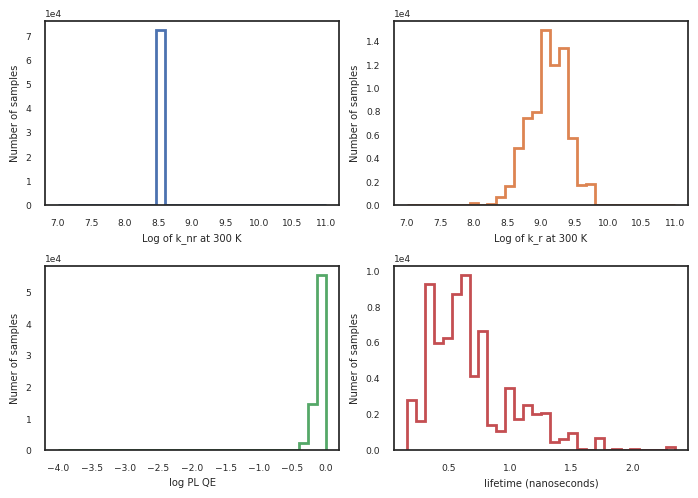

(<Figure size 700x500 with 4 Axes>,
 array([<Axes: xlabel='Log of k_nr at 300 K', ylabel='Number of samples'>,
        <Axes: xlabel='Log of k_r at 300 K', ylabel='Number of samples'>,
        <Axes: xlabel='log PL QE', ylabel='Numer of samples'>,
        <Axes: xlabel='lifetime (nanoseconds)', ylabel='Numer of samples'>],
       dtype=object))

In [23]:
plot_utils.plot_lifetime(
    reader,
    discard=100,
    filter_log_likelihood=filter_log_likelihood,
)

AttributeError: You must run the sampler with 'store == True' before accessing the results

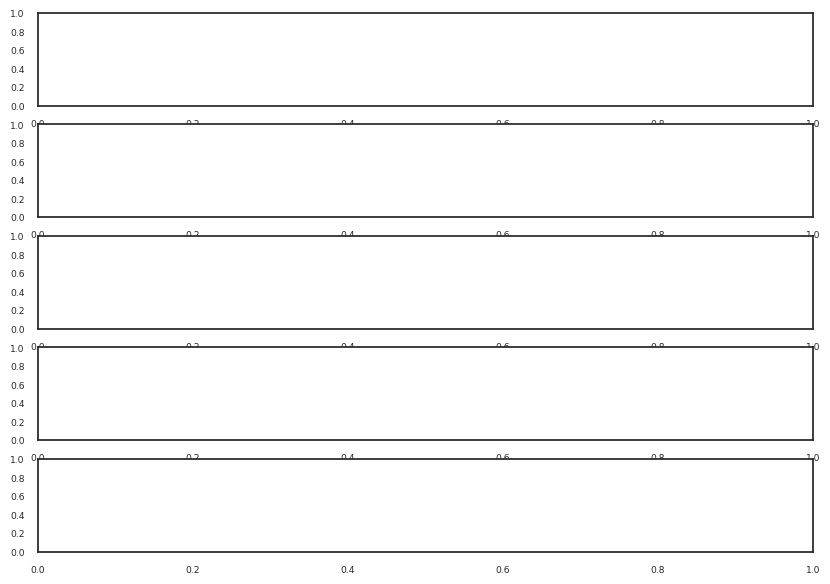

In [24]:
import importlib

importlib.reload(plot_utils)
index_analyse_list = [2, 19]
fig, axes = plt.subplots(5, figsize=(10, 7))
for i, index_analyse in enumerate(index_analyse_list):
    test_id = df_all["test_id"].loc[index_analyse]
    label = (
        df_all["csv_name_pl"]
        .loc[index_analyse]
        .split("/")[-1]
        .replace(".csv", "")
        .replace("_mod_split", " ")
        .replace("_split", " ")
    )
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder="fit_experimental_emcee_pl/fit_data_base/"
    )
    filename = model_config_save["save_folder"] + "/sampler.h5"
    reader = emcee.backends.HDFBackend(filename, name="multi_core")
    fig, ax = plot_utils.plot_distribution_multi(
        reader,
        model_config_save,
        discard=200,
        filter_log_likelihood=True,
        fig=fig,
        axes=axes,
        color=f"C{i}",
        legend_label=label,
    )
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i, index_analyse in enumerate(index_analyse_list):
    test_id = df_all["test_id"].loc[index_analyse]
    label = (
        df_all["csv_name_pl"]
        .loc[index_analyse]
        .split("/")[-1]
        .replace(".csv", "")
        .replace("_mod_split", " ")
        .replace("_split", " ")
    )
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder="fit_experimental_emcee_pl/fit_data_base/"
    )
    filename = model_config_save["save_folder"] + "/sampler.h5"
    reader = emcee.backends.HDFBackend(filename, name="multi_core")
    fig, ax = plot_utils.plot_fit_statistics_multi(
        reader,
        range_log_prior=(-500, 0),
        discard=200,
        range_chi_square=(0, 3),
        filter_log_likelihood=True,
        fig=fig,
        ax=ax,
        legend_label=label,
        color=f"C{i}",
    )

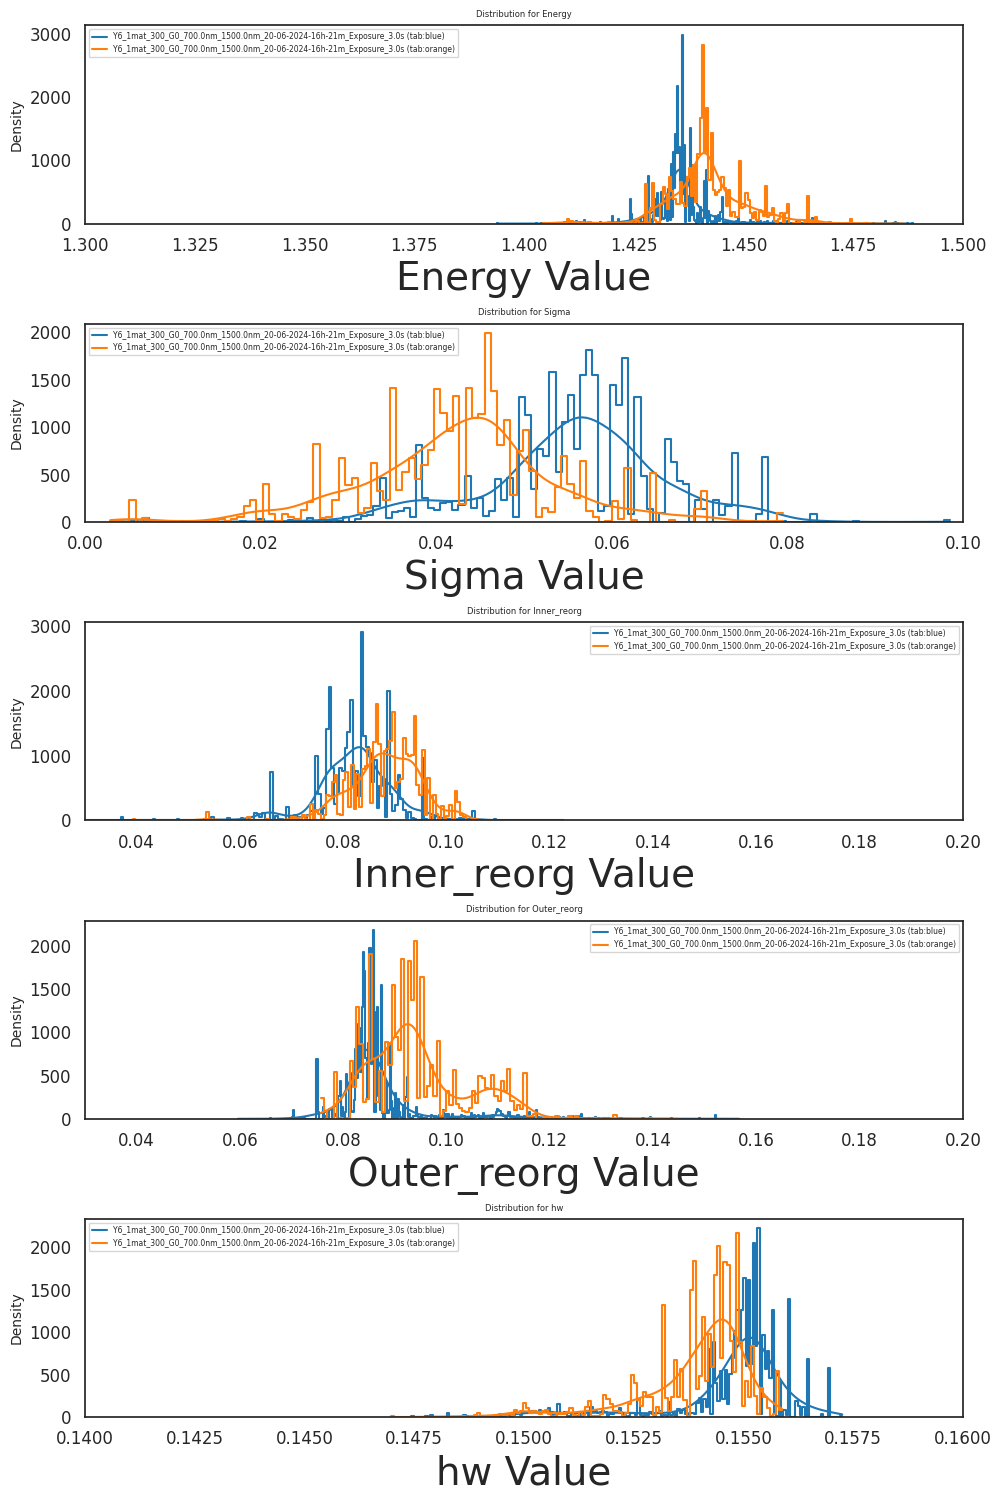

In [ ]:
def plot_overlay_distributions(index_analyse_list):
    # Assuming each index corresponds to a unique configuration but shares parameter labels
    n_params = 5  # Assuming there are 5 parameters
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 15), squeeze=False)

    colors = [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
    ]  # More colors can be added if needed
    labels = [
        "Energy",
        "Sigma",
        "Inner_reorg",
        "Outer_reorg",
        "hw",
    ]  # Placeholder parameter names

    axis_limits = [
        (1.3, 1.5),  # Limits for Energy
        (0, 0.1),  # Limits for Sigma
        (0.03, 0.2),  # LO
        (0.03, 0.2),  # Li
        (0.14, 0.16),  # hw
    ]

    for i in range(n_params):
        for j, index_analyse in enumerate(index_analyse_list):
            test_id = df_all["test_id"].loc[index_analyse]
            label = (
                df_all["csv_name_pl"]
                .loc[index_analyse]
                .split("/")[-1]
                .replace(".csv", "")
                .replace("_mod_split", " ")
                .replace("_split", " ")
            )
            model_config, model_config_save = config_utils.load_model_config(
                test_id,
                database_folder="fit_experimental_emcee_pl/fit_data_base/",
            )
            filename = model_config_save["save_folder"] + "/sampler.h5"
            reader = emcee.backends.HDFBackend(filename, name="multi_core")

            # Extract the samples for the ith parameter and discard the initial steps
            samples = reader.get_chain(discard=0, flat=True)[:, i]
            sns.histplot(
                samples,
                ax=axes[i, 0],
                kde=True,
                color=colors[j % len(colors)],
                label=f"{label} ({colors[j % len(colors)]})",
                element="step",
                fill=False,
                kde_kws={"bw_adjust": 2},
            )

        axes[i, 0].set_title(f"Distribution for {labels[i]}")
        axes[i, 0].set_ylabel("Density", fontsize=10)
        axes[i, 0].set_xlabel(f"{labels[i]} Value")
        axes[i, 0].set_xlim(axis_limits[i])
        axes[i, 0].legend()
        axes[i, 0].tick_params(
            axis="both", which="major", labelsize=12
        )  # Increase tick label size

    plt.tight_layout()
    plt.show()


# Example usage:
index_analyse_list = [0, 3]
plot_overlay_distributions(index_analyse_list)
